In [117]:
import os
import shared.data_utils as data_utils
import torch
from torch.utils.data import Dataset
import numpy as np
import modules

## Prepare synthetic dataset

C:\Users\charl\AppData\Local\Temp\ipykernel_10028\953285777.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  {'vertices': data_utils.dequantize_verts(torch.tensor(shape['vertices'])),
C:\Users\charl\AppData\Local\Temp\ipykernel_10028\953285777.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'faces': data_utils.unflatten_faces(torch.tensor(shape['faces']))})


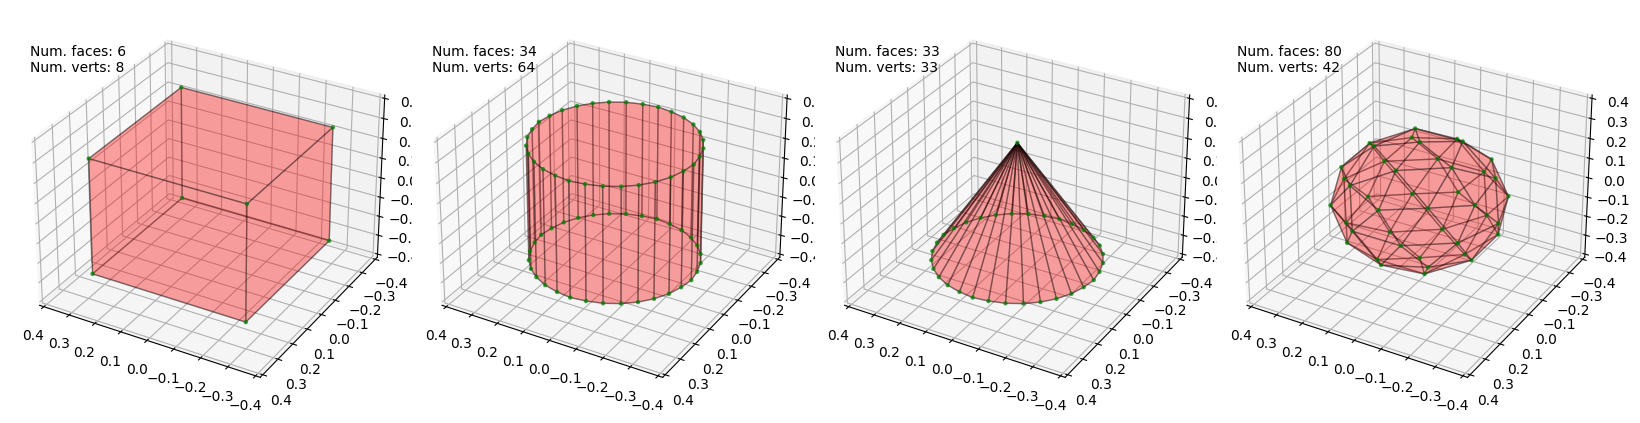

In [118]:
import importlib
importlib.reload(data_utils) 


class MeshDataset(Dataset):
    def __init__(self, mesh_list):
        self.mesh_list = mesh_list 

    def __len__(self):
        return len(self.mesh_list)

    def __getitem__(self, idx):
        return self.mesh_list[idx]
    
    def map(self, func):
        for i in range(len(self.mesh_list)):
           self.mesh_list[i] = func(self.mesh_list[i])
        return self

# Prepare synthetic dataset
ex_list = []
for k, mesh in enumerate(['cube', 'cylinder', 'cone', 'icosphere']):
    mesh_dict = data_utils.load_process_mesh(
        os.path.join('meshes', '{}.obj'.format(mesh)))
    mesh_dict['class_label'] = k
    mesh_dict['vertices'] = torch.tensor(mesh_dict['vertices'])
    mesh_dict['faces'] = torch.tensor(mesh_dict['faces'])
    ex_list.append(mesh_dict)


#synthetic_dataset = torch.utils.data.DataLoader(ex_list, batch_size=1)
synthetic_dataset = MeshDataset(ex_list)

# Plot the meshes
mesh_list = []
for shape in synthetic_dataset:
  mesh_list.append(
      {'vertices': data_utils.dequantize_verts(torch.tensor(shape['vertices'])),
        'faces': data_utils.unflatten_faces(torch.tensor(shape['faces']))})
data_utils.plot_meshes(mesh_list, ax_lims=0.4)

In [119]:
batch_size = 4

## Create vertex model

In [120]:
import importlib
importlib.reload(data_utils) 
importlib.reload(modules) 
import shared.math_utils as math_utils
importlib.reload(math_utils) 

# Prepare the dataset for vertex model training
def pad_batch(batch):
    items = np.array([list(item.values()) for item in batch])
    packed_dict = {}
    for i, key in enumerate(batch[0].keys()):
        if not isinstance(items[:, i][0], torch.Tensor):
            packed_dict[key] = torch.tensor(items[:, i].astype(np.int64))
            continue # dont pad class labels
        padded_values = torch.nn.utils.rnn.pad_sequence(items[:, i], batch_first=True)
        packed_dict[key] = padded_values
    return packed_dict

vertex_model_dataset = data_utils.make_vertex_model_dataset(
    synthetic_dataset, apply_random_shift=False)

vertex_model_dataloader = torch.utils.data.DataLoader(vertex_model_dataset, shuffle=True, batch_size=batch_size, collate_fn=pad_batch)

vertex_model_batch = next(iter(vertex_model_dataloader))
#print(vertex_model_batch)

max_num_input_verts=250

decoder_config={
        'embd_size': 512,
        'n_head': 8,
        'fc_size': 1024, 
        'num_layers': 4,
        'dropout_rate': 0.2
}
""" decoder_config={
        'embd_size': 512,
        'fc_size': 1024, 
        'num_layers': 4,
        'dropout_rate': 0.2
} """
# Create vertex model
vertex_model = modules.VertexModel(
    decoder_config=decoder_config,
    class_conditional=True,
    num_classes=4,
    max_num_input_verts=max_num_input_verts,
    quantization_bits=8
)
vertex_model_pred_dist = vertex_model(vertex_model_batch)

vertex_model_loss = -torch.sum(
    vertex_model_pred_dist.log_prob(vertex_model_batch['vertices_flat']) * 
    vertex_model_batch['vertices_flat_mask'])

vertex_samples = vertex_model.sample(
    4, context=vertex_model_batch, max_sample_length=200, top_p=0.95,
    recenter_verts=False, only_return_complete=False)

#print(vertex_model_batch)
#print(vertex_model_pred_dist)
#print(vertex_samples)

C:\Users\charl\AppData\Local\Temp\ipykernel_10028\4208321634.py:9: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  items = np.array([list(item.values()) for item in batch])
C:\Users\charl\AppData\Local\Temp\ipykernel_10028\4208321634.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  items = np.array([list(item.values()) for item in batch])


In [121]:
import math
from numbers import Number

import torch
from torch.distributions import Distribution, constraints
from torch.distributions.utils import broadcast_all

CONST_SQRT_2 = math.sqrt(2)
CONST_INV_SQRT_2PI = 1 / math.sqrt(2 * math.pi)
CONST_INV_SQRT_2 = 1 / math.sqrt(2)
CONST_LOG_INV_SQRT_2PI = math.log(CONST_INV_SQRT_2PI)
CONST_LOG_SQRT_2PI_E = 0.5 * math.log(2 * math.pi * math.e)


class TruncatedStandardNormal(Distribution):
    """
    Truncated Standard Normal distribution
    https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    """

    arg_constraints = {
        'a': constraints.real,
        'b': constraints.real,
    }
    has_rsample = True

    def __init__(self, a, b, validate_args=None):
        self.a, self.b = broadcast_all(a, b)
        if isinstance(a, Number) and isinstance(b, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.a.size()
        super(TruncatedStandardNormal, self).__init__(batch_shape, validate_args=validate_args)
        if self.a.dtype != self.b.dtype:
            raise ValueError('Truncation bounds types are different')
        if any((self.a >= self.b).view(-1,).tolist()):
            raise ValueError('Incorrect truncation range')
        eps = torch.finfo(self.a.dtype).eps
        self._dtype_min_gt_0 = eps
        self._dtype_max_lt_1 = 1 - eps
        self._little_phi_a = self._little_phi(self.a)
        self._little_phi_b = self._little_phi(self.b)
        self._big_phi_a = self._big_phi(self.a)
        self._big_phi_b = self._big_phi(self.b)
        self._Z = (self._big_phi_b - self._big_phi_a).clamp_min(eps)
        self._log_Z = self._Z.log()
        little_phi_coeff_a = torch.nan_to_num(self.a, nan=math.nan)
        little_phi_coeff_b = torch.nan_to_num(self.b, nan=math.nan)
        self._lpbb_m_lpaa_d_Z = (self._little_phi_b * little_phi_coeff_b - self._little_phi_a * little_phi_coeff_a) / self._Z
        self._mean = -(self._little_phi_b - self._little_phi_a) / self._Z
        self._variance = 1 - self._lpbb_m_lpaa_d_Z - ((self._little_phi_b - self._little_phi_a) / self._Z) ** 2
        self._entropy = CONST_LOG_SQRT_2PI_E + self._log_Z - 0.5 * self._lpbb_m_lpaa_d_Z

    @constraints.dependent_property
    def support(self):
        return constraints.interval(self.a, self.b)

    @property
    def mean(self):
        return self._mean

    @property
    def variance(self):
        return self._variance

    @property
    def entropy(self):
        return self._entropy

    @property
    def auc(self):
        return self._Z

    @staticmethod
    def _little_phi(x):
        return (-(x ** 2) * 0.5).exp() * CONST_INV_SQRT_2PI

    @staticmethod
    def _big_phi(x):
        return 0.5 * (1 + (x * CONST_INV_SQRT_2).erf())

    @staticmethod
    def _inv_big_phi(x):
        return CONST_SQRT_2 * (2 * x - 1).erfinv()

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return ((self._big_phi(value) - self._big_phi_a) / self._Z).clamp(0, 1)

    def icdf(self, value):
        return self._inv_big_phi(self._big_phi_a + value * self._Z)

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return CONST_LOG_INV_SQRT_2PI - self._log_Z - (value ** 2) * 0.5

    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        p = torch.empty(shape, device=self.a.device).uniform_(self._dtype_min_gt_0, self._dtype_max_lt_1)
        return self.icdf(p)


class TruncatedNormal(TruncatedStandardNormal):
    """
    Truncated Normal distribution
    https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    """

    has_rsample = True

    def __init__(self, loc, scale, a, b, validate_args=None):
        self.loc, self.scale, a, b = broadcast_all(loc, scale, a, b)
        a = (a - self.loc) / self.scale
        b = (b - self.loc) / self.scale
        super(TruncatedNormal, self).__init__(a, b, validate_args=validate_args)
        self._log_scale = self.scale.log()
        self._mean = self._mean * self.scale + self.loc
        self._variance = self._variance * self.scale ** 2
        self._entropy += self._log_scale

    def _to_std_rv(self, value):
        return (value - self.loc) / self.scale

    def _from_std_rv(self, value):
        return value * self.scale + self.loc

    def cdf(self, value):
        return super(TruncatedNormal, self).cdf(self._to_std_rv(value))

    def icdf(self, value):
        return self._from_std_rv(super(TruncatedNormal, self).icdf(value))

    def log_prob(self, value):
        return super(TruncatedNormal, self).log_prob(self._to_std_rv(value)) - self._log_scale

In [122]:
import numpy as np
import torch


def parameterized_truncated_normal(uniform, mu, sigma, a, b):
    normal = torch.distributions.normal.Normal(0, 1)

    alpha = (a - mu) / sigma
    beta = (b - mu) / sigma

    alpha_normal_cdf = normal.cdf(alpha)
    p = alpha_normal_cdf + (normal.cdf(beta) - alpha_normal_cdf) * uniform

    p = p.numpy()
    one = np.array(1, dtype=p.dtype)
    epsilon = np.array(np.finfo(p.dtype).eps, dtype=p.dtype)
    v = np.clip(2 * p - 1, -one + epsilon, one - epsilon)
    x = mu + sigma * np.sqrt(2) * torch.erfinv(torch.from_numpy(v))
    x = torch.clamp(x, a, b)

    return x

#parameterized_truncated_normal(torch.from_numpy(np.random.uniform(0, 1, (2,3))),
#                                                        0, shift_factor*255, -max_shift_neg, max_shift_pos) 

In [123]:
import importlib
importlib.reload(data_utils) 
importlib.reload(modules) 
import shared.math_utils as math_utils
importlib.reload(math_utils) 
import math

def sample_no_grad_trunc_normal(num_samples, mean, std, a, b):
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + torch.erf(x / math.sqrt(2.))) / 2.

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)
        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        num_samples = torch.tensor(num_samples).shape
        tensor = torch.distributions.uniform.Uniform(2 * l - 1, 2 * u - 1).sample(num_samples)
        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()
        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)
        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor

def random_shift(vertices, shift_factor=0.25):
  #Apply random shift to vertices.
  max_shift_pos = (255 - torch.max(vertices, dim=0)[0]).float()
  max_shift_pos = torch.maximum(max_shift_pos, torch.tensor(1e-9))

  max_shift_neg = torch.min(vertices, dim=0)[0].float()
  max_shift_neg = torch.maximum(max_shift_neg, torch.tensor(1e-9))

  sample = sample_no_grad_trunc_normal(
    1,
    torch.zeros([1,3]), 
    shift_factor*255, 
    -max_shift_neg,
    max_shift_pos).int()
  
  vertices += sample
  return vertices

x = torch.tensor([[[-0.7052,  0.2718,  0.7226],
         [-1.3992,  0.3387,  0.6098]]])


random_shift(x)

tensor([[[  6.2948,  35.2718,  95.7226],
         [  3.6008,  47.3387, 152.6098]]])

## Create face model

In [124]:
import importlib
importlib.reload(data_utils) 
importlib.reload(modules) 
import shared.math_utils as math_utils
importlib.reload(math_utils) 

face_model_dataset = data_utils.make_face_model_dataset(
    synthetic_dataset, apply_random_shift=False)

face_model_dataloader = torch.utils.data.DataLoader(face_model_dataset, shuffle=True, batch_size=batch_size, collate_fn=pad_batch)
face_model_batch = next(iter(face_model_dataloader))

encoder_config={
        'embd_size': 512,
        'fc_size': 1024, 
        'num_layers': 4,
        'dropout_rate': 0.1
}
decoder_config={
    'embd_size': 512,
    'fc_size': 1024, 
    'num_layers': 4,
    'dropout_rate': 0.1
}

# Create face model
face_model = modules.FaceModel(
    encoder_config=encoder_config,
    decoder_config=decoder_config,
    class_conditional=False,
    max_seq_length=500,
    quantization_bits=8,
    max_num_input_verts=max_num_input_verts,
    decoder_cross_attention=True,
    use_discrete_vertex_embeddings=True,
)
face_model_pred_dist = face_model(face_model_batch)
face_model_loss = -torch.sum(face_model_pred_dist.log_prob(face_model_batch['faces']) * 
    face_model_batch['faces_mask'])

face_samples = face_model.sample(
    context=vertex_samples, max_sample_length=500, top_p=0.95,
    only_return_complete=False)
#print(face_model_batch)
#print(face_model_pred_dist)
#print(face_samples)


C:\Users\charl\AppData\Local\Temp\ipykernel_10028\4208321634.py:9: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  items = np.array([list(item.values()) for item in batch])
C:\Users\charl\AppData\Local\Temp\ipykernel_10028\4208321634.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  items = np.array([list(item.values()) for item in batch])


C:\Users\charl\AppData\Local\Temp\ipykernel_10028\4208321634.py:9: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  items = np.array([list(item.values()) for item in batch])
C:\Users\charl\AppData\Local\Temp\ipykernel_10028\4208321634.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  items = np.array([list(item.values()) for item in batch])


Step 0
Loss (vertices) 2561.767822265625
Loss (faces) 595.49072265625


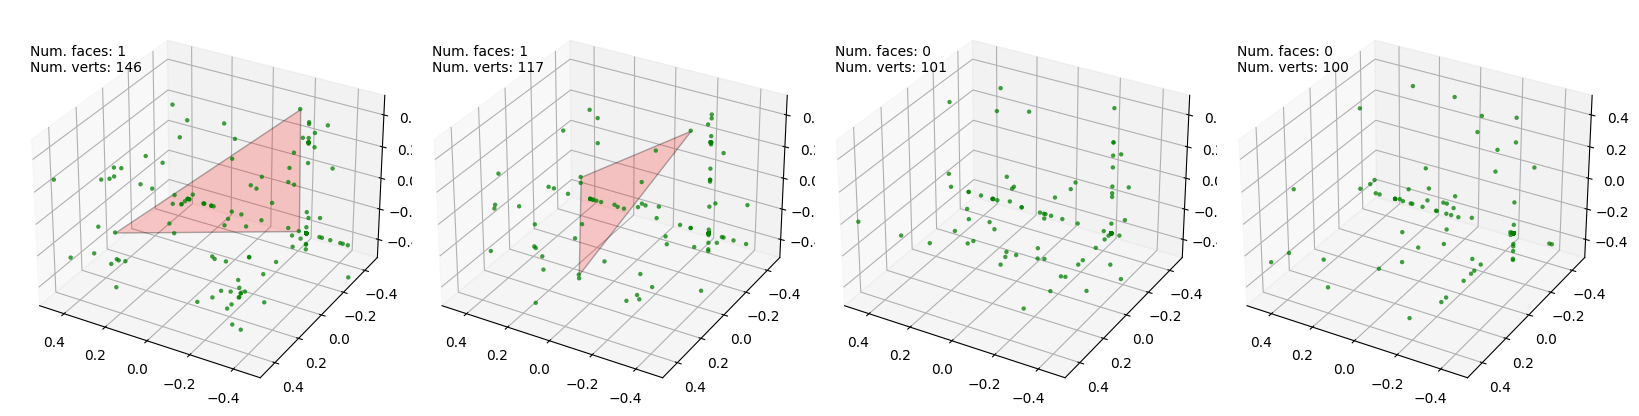

Step 5
Loss (vertices) 1608.649169921875
Loss (faces) 587.6534423828125


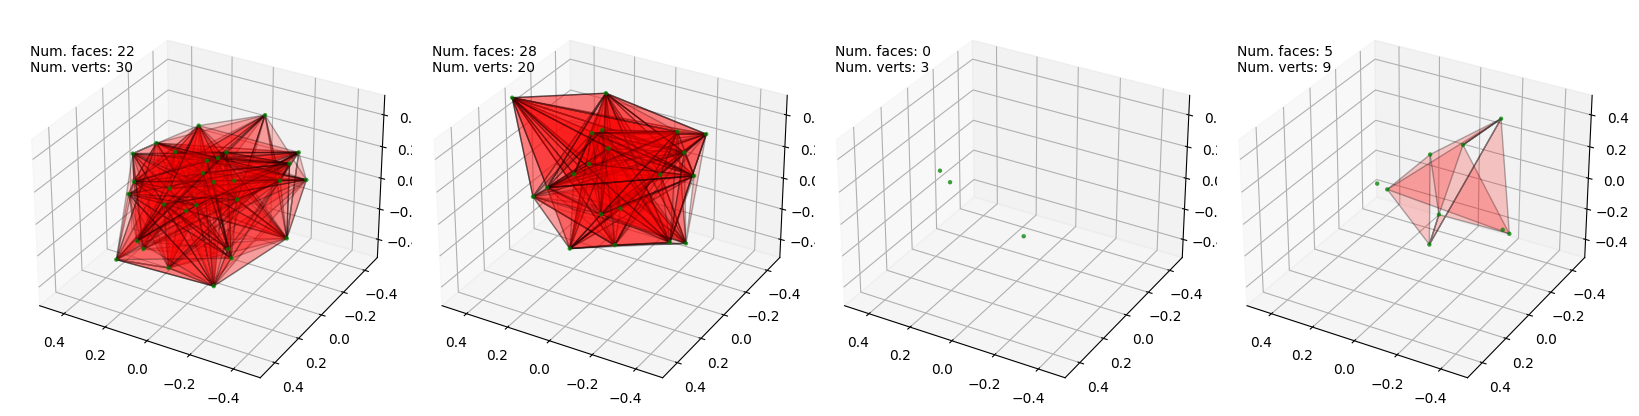

Step 10
Loss (vertices) 1328.349365234375
Loss (faces) 571.1404418945312


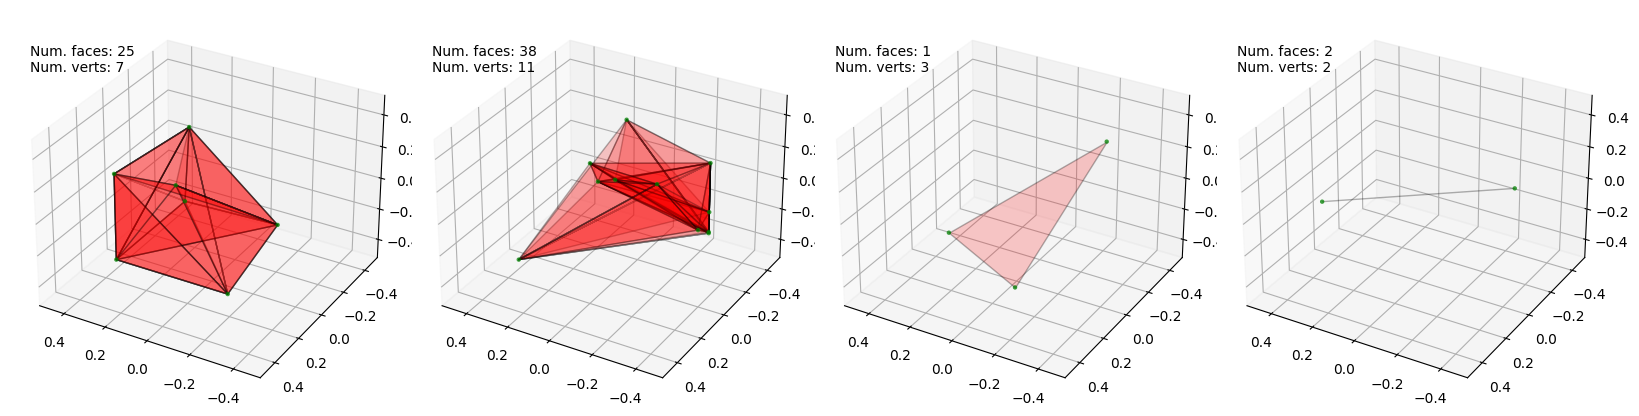

Step 15
Loss (vertices) 1127.7542724609375
Loss (faces) 556.4891967773438


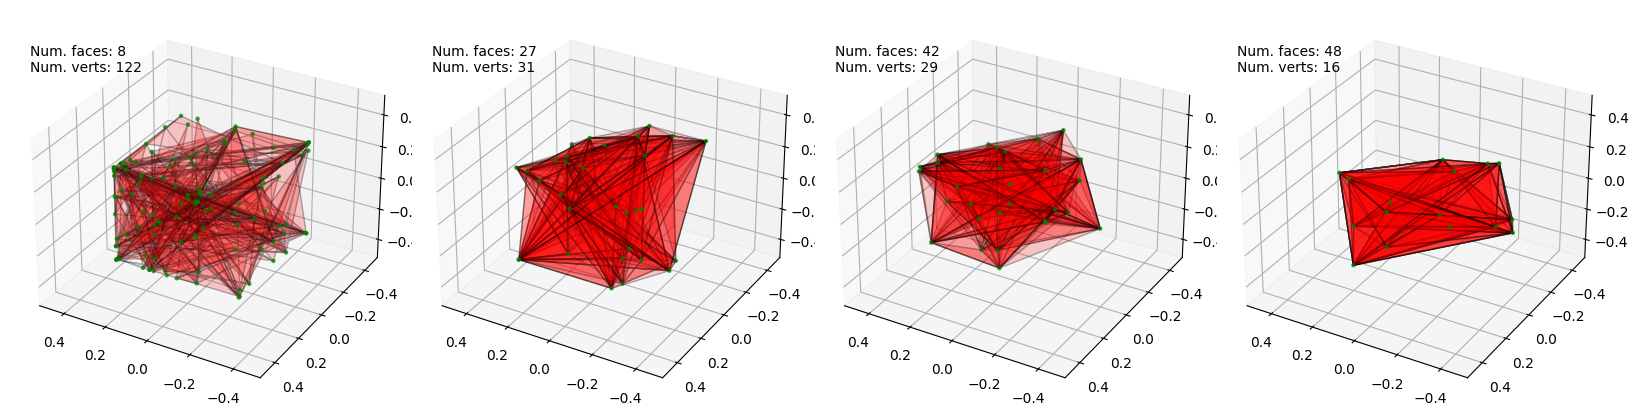

Step 20
Loss (vertices) 981.800048828125
Loss (faces) 534.7345581054688


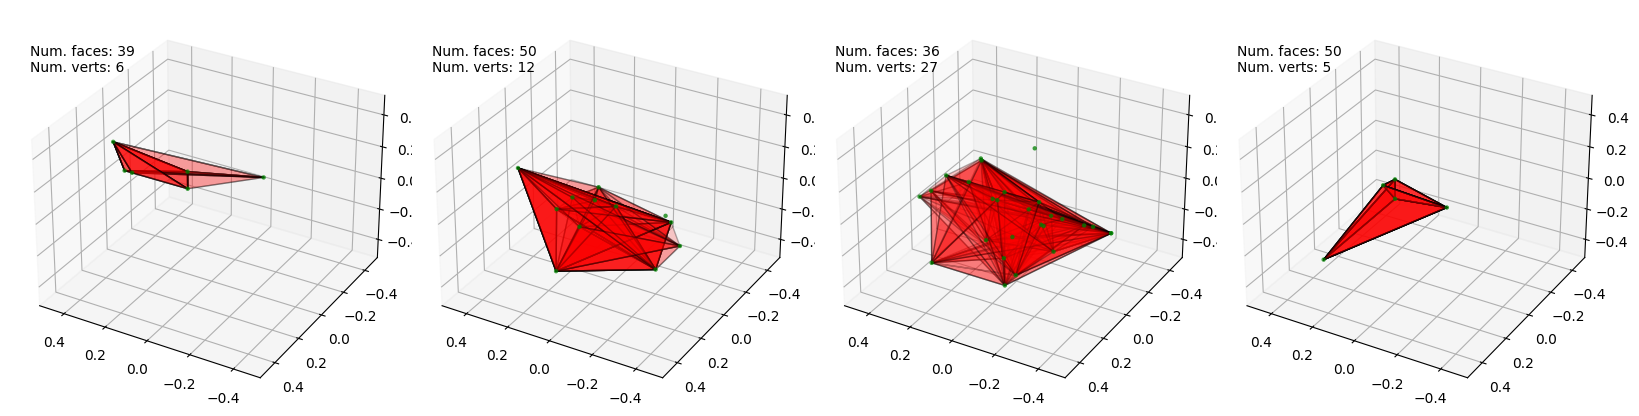

Step 25
Loss (vertices) 898.2394409179688
Loss (faces) 514.8789672851562
[{'vertices': tensor([[ 0.1078, -0.2922, -0.2922]]), 'faces': [[tensor(0), tensor(0), tensor(0)]], 'vertices_conditional': None, 'pointcloud': None, 'class_name': None}, {'vertices': tensor([[-0.0020,  0.2490, -0.0020],
        [ 0.2882,  0.2882,  0.2882],
        [ 0.2882,  0.2882,  0.2882]]), 'faces': [[tensor(1), tensor(1), tensor(1)], [tensor(2), tensor(2), tensor(2)], [tensor(2), tensor(2), tensor(2)], [tensor(2), tensor(2), tensor(1)]]}, {'vertices': tensor([[ 0.2882,  0.2882, -0.2922]]), 'faces': [[tensor(0), tensor(0), tensor(0)], [tensor(0), tensor(0), tensor(0)], [tensor(0), tensor(0), tensor(0)]]}, {'vertices': tensor([[-0.0020,  0.2882,  0.2882]]), 'faces': []}]
Step 30
Loss (vertices) 783.4840698242188
Loss (faces) 510.3628234863281
[{'vertices': tensor([[ 0.2882, -0.2922, -0.2922],
        [ 0.2882,  0.2882,  0.2882],
        [ 0.2882,  0.2882,  0.2882]]), 'faces': [[tensor(2), tensor(0), tensor(0), 

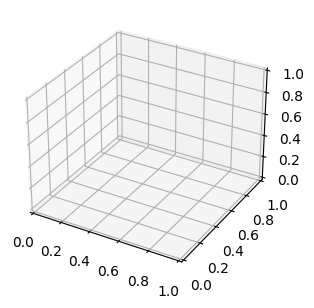

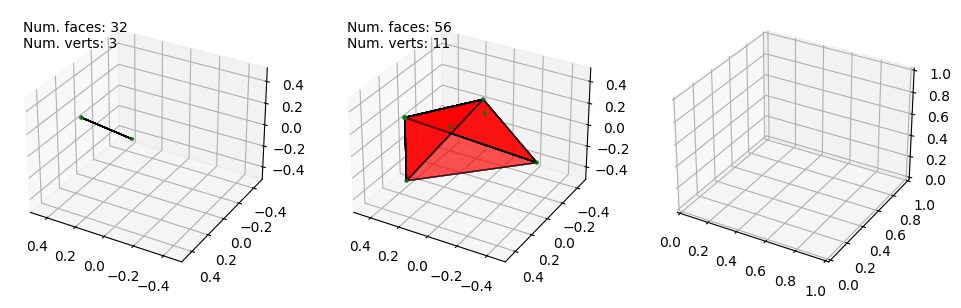

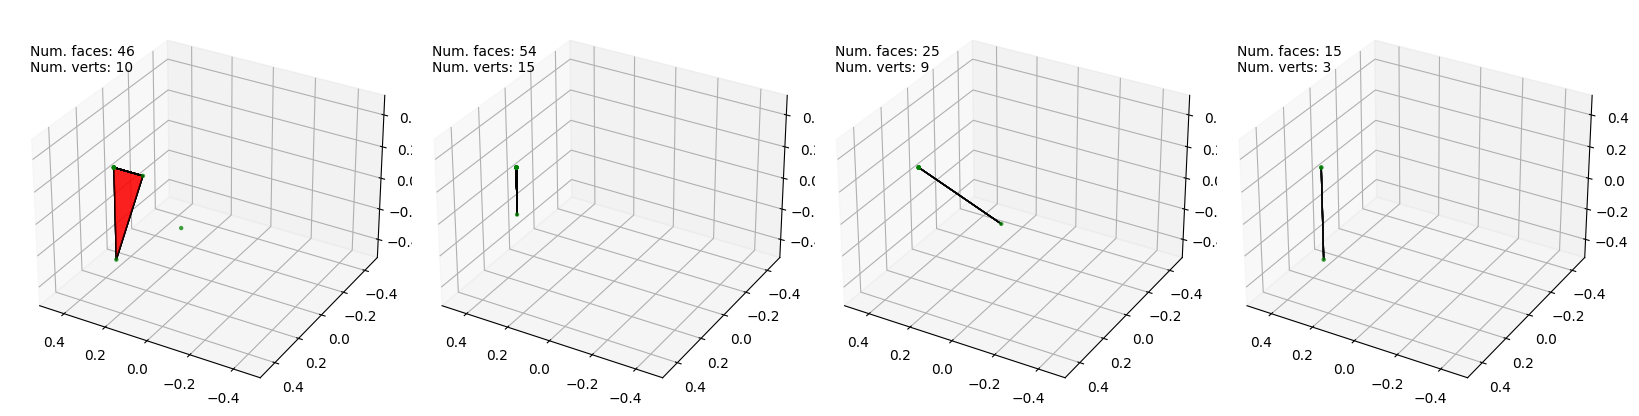

Step 40
Loss (vertices) 514.7376098632812
Loss (faces) 507.24847412109375


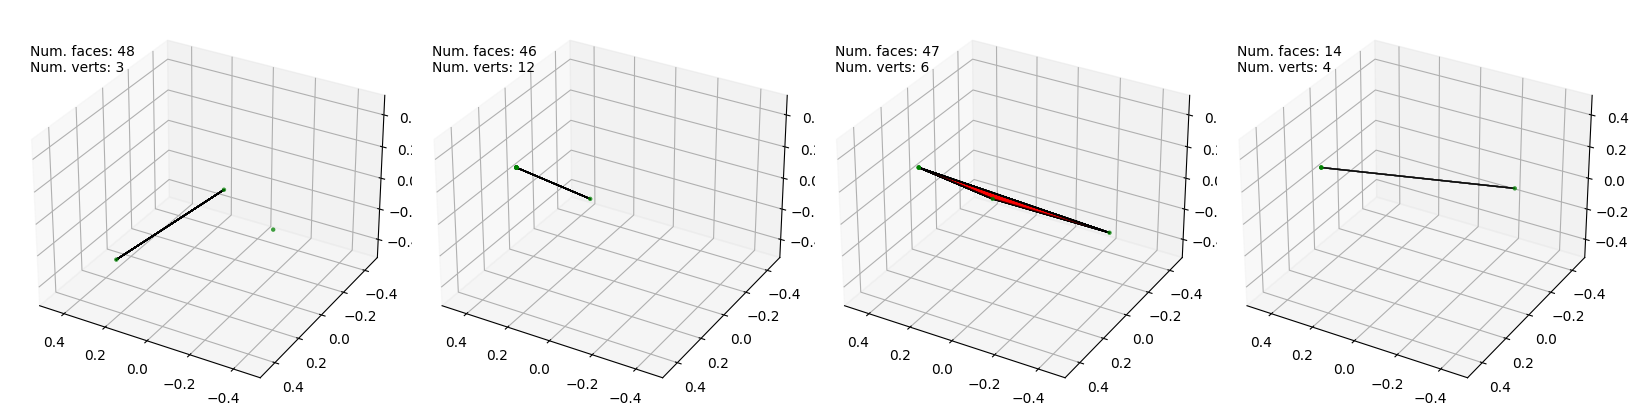

Step 45
Loss (vertices) 389.3927917480469
Loss (faces) 505.8551330566406


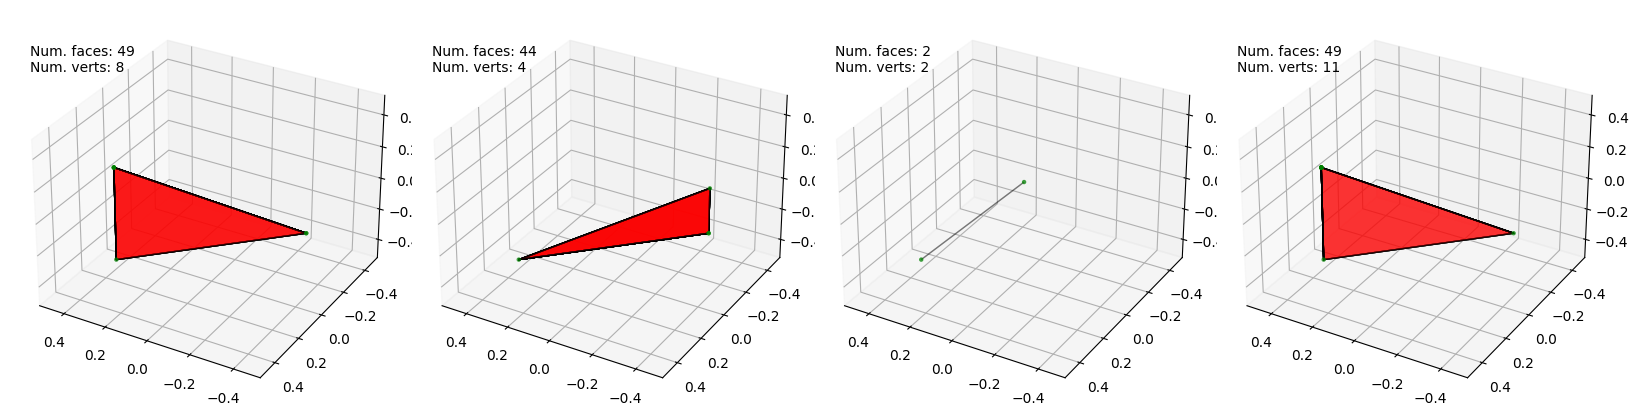

Step 50
Loss (vertices) 277.7489013671875
Loss (faces) 502.2052917480469


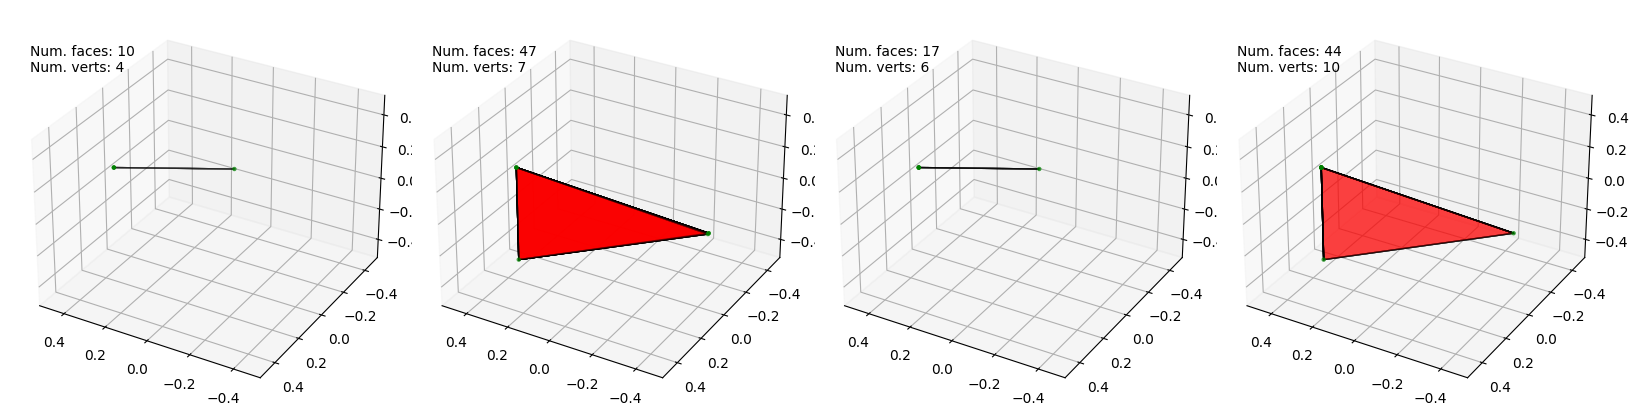

Step 55
Loss (vertices) 187.7547607421875
Loss (faces) 500.4653015136719


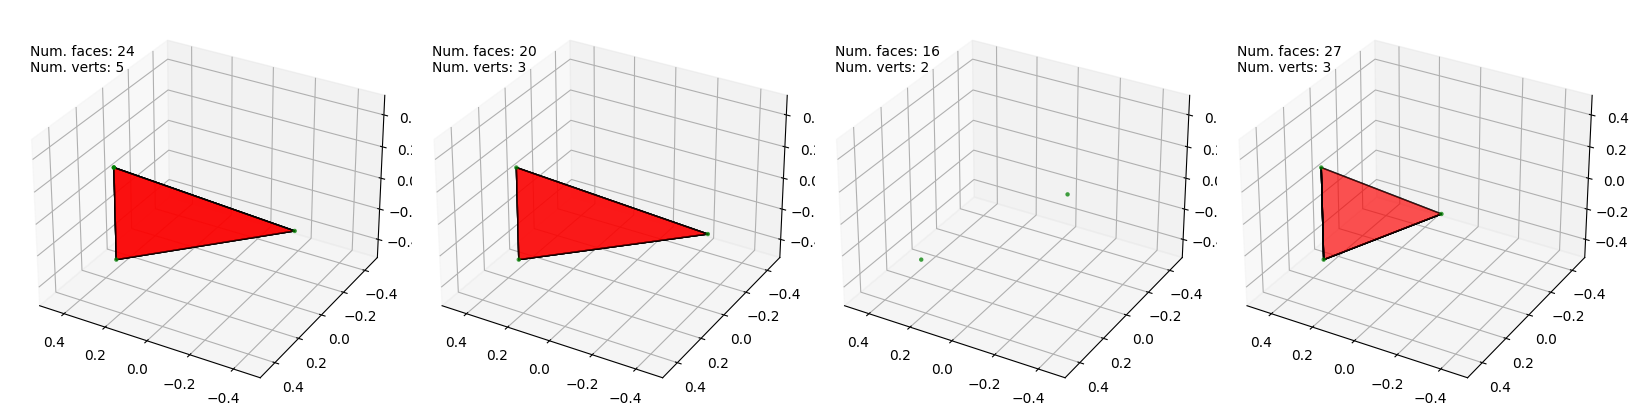

Step 60
Loss (vertices) 116.18055725097656
Loss (faces) 499.76080322265625


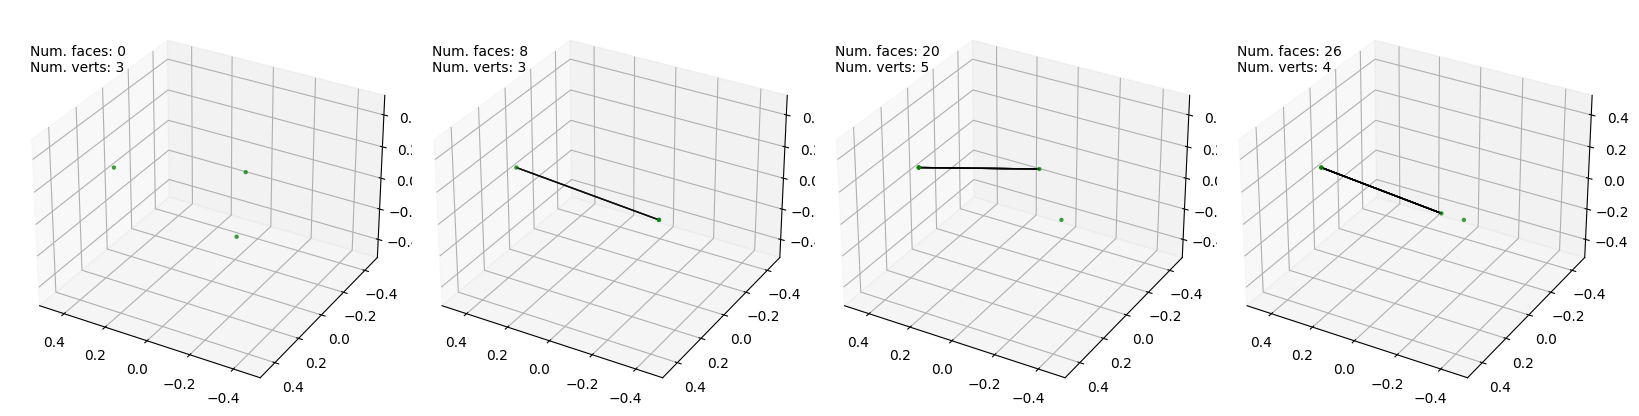

Step 65
Loss (vertices) 92.33308410644531
Loss (faces) 500.7699890136719


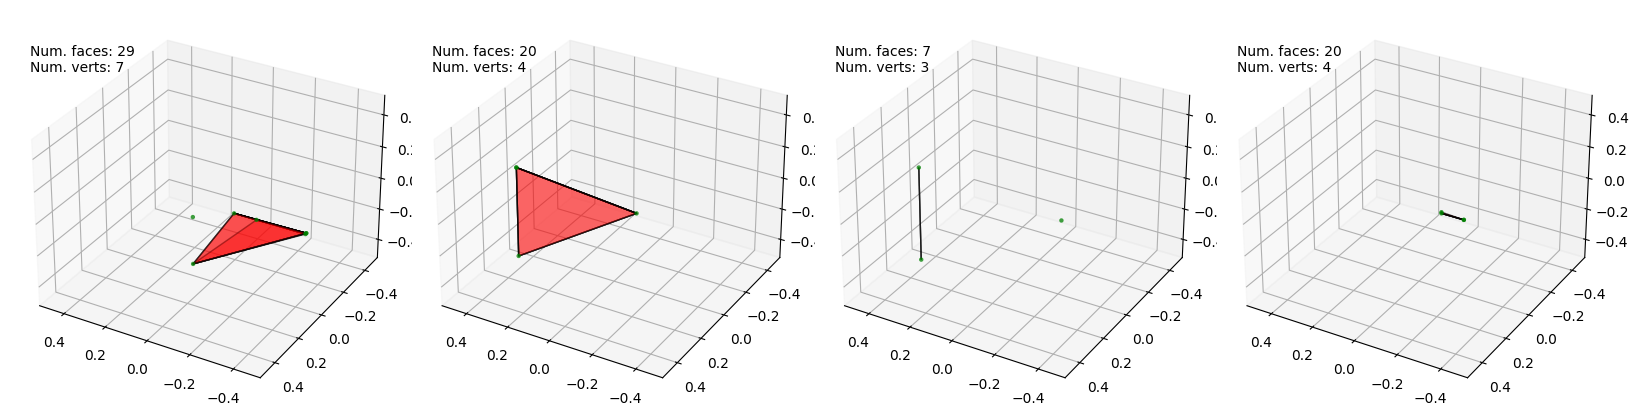

In [125]:
# Optimization settings
#learning_rate = 1e-3
learning_rate = 5e-4
training_steps = 5000
log_step = 5
n_samples = 4
# Create an optimizer an minimize the summed log probability of the mesh 
# sequences
#optimizer = tf.train.AdamOptimizer(learning_rate)
face_model_optim = torch.optim.Adam(face_model.parameters(), lr=learning_rate)
vertex_model_optim = torch.optim.Adam(vertex_model.parameters(), lr=learning_rate)
#vertex_model_optim_op = optimizer.minimize(vertex_model_loss)
#face_model_optim_op = optimizer.minimize(face_model_loss)

def get_batch_from_dataloader(dataloader):
  try:
    batch = next(iter(dataloader))
  except StopIteration:
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, shuffle=True, batch_size=batch_size, collate_fn=pad_batch)
    batch = next(iter(dataloader))
  return batch

# Training loop
for n in range(training_steps):
    vertex_model_batch = get_batch_from_dataloader(vertex_model_dataloader)
    vertex_model_pred_dist = vertex_model(vertex_model_batch)
    vertex_model_loss = -torch.sum(
    	vertex_model_pred_dist.log_prob(vertex_model_batch['vertices_flat']) * 
    	vertex_model_batch['vertices_flat_mask'])  
        
    face_model_batch = get_batch_from_dataloader(face_model_dataloader)
    face_model_pred_dist = face_model(face_model_batch)
    face_model_loss = -torch.sum(face_model_pred_dist.log_prob(face_model_batch['faces']) * 
		  face_model_batch['faces_mask'])

    vertex_model_optim.zero_grad()
    vertex_model_loss.backward()
    vertex_model_optim.step()

    face_model_optim.zero_grad()
    face_model_loss.backward()
    face_model_optim.step()

    if n % log_step == 0:
        print('Step {}'.format(n))
        print('Loss (vertices) {}'.format(vertex_model_loss))
        print('Loss (faces) {}'.format(face_model_loss))    
        vertex_samples = vertex_model.sample(
        n_samples, context=vertex_model_batch, max_sample_length=200, top_p=0.95,
        recenter_verts=False, only_return_complete=False)    
        face_samples = face_model.sample(
        context=vertex_samples, max_sample_length=500, top_p=0.95,
        only_return_complete=False)    
        mesh_list = []
        for n in range(min(n_samples, batch_size)):
            mesh_list.append(
            	{
            		'vertices': vertex_samples['vertices'][n][:vertex_samples['num_vertices'][n]],
            		'faces': data_utils.unflatten_faces(
            			face_samples['faces'][n][:face_samples['num_face_indices'][n]])
            	}
            )
        try:
          data_utils.plot_meshes(mesh_list, ax_lims=0.5)
        except:
          print(mesh_list)
    